In [4]:
# %matplotlib qt5
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


#### helper functions

In [5]:
### dynamics
def iidGaussian(stats,shapem):
	mu,sig = stats[0],stats[1]
	nx,ny = shapem[0],shapem[1]
	return np.random.normal(mu,sig,(nx,ny))

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d
def equations(x,data):
    '''
    Function: compute the largest real eigenvalue outlier of the matrix with chain motifs
    eqleft = (outlier**2+gaverage**2*tau)*(outlier**2-gaverage**2*tau*(N-1))
    eqright = outlier*eigvAm[0]*(outlier**2-gaverage**2*tau*(N-1))+gaverage**2*tau*eigvAm[0]*N
    f(outlier) = eqleft - eqright = 0
    params:
    data = [g, tau_chn, lambda_0, N]
    '''
    outlier = x
    gaverage,tau,eigvAm,N = data[0],data[1],data[2],data[3]
    eqleft = (outlier**2+gaverage**2*tau)*(outlier**2-gaverage**2*tau*(N-1))
    eqright = outlier*eigvAm*(outlier**2-gaverage**2*tau*(N-1))+gaverage**2*tau*eigvAm*outlier*N
    # eqright = outlier*eigvAm*(outlier**2+gaverage**2*tau)
    
    return (eqleft-eqright)
#### compute corresponding parameters and variables in the equivalent sparse networks
### Epopulation
def compute_AdjacencyParams(x,JE,JI,sigmae,sigmai,Nparams):
    ce,ci = x[0],x[1]
    NE,NI = Nparams[0],Nparams[1]
    N = NE+NI
    J = JE/NE/ce 
    Jg = JI/NI/ci
    
    sigmae2 = J**2*ce*(1-ce)*N 
    sigmai2 = Jg**2*ci*(1-ci)*N 
    
    resultse = sigmae**2-sigmae2
    resultsi = sigmai**2-sigmai2
    return np.array([resultse,resultsi])

#### Network with Gaussian-distributed synaptic weights

In [6]:
JE, JI = 0.65,1.65#current_paradoxical#1.5, 2.0#previous_no_paradoxical
g_max,tau_max = 0.2,0.1 # 
ntau,trials   = 11,30+6#
tau_series = np.linspace(0,tau_max,ntau)#np.linspace(0,0.2,ntau)

In [7]:
idnn = 1
nn = [600,800,1600] ## Network size: 750, 1000, 2000
NE, NI = nn[idnn], nn[idnn] 
gamma = 1/4
NI = int(NE*gamma)
N = NE+NI
### recompute JE and JI 
# barJE, barJI = 0.65/800,1.65/200 
# JE, JI = barJE*NE, barJI*NI  
print('new JE and JI:',JE, JI)
Nparams = np.array([NE,NI])
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
# recordings
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
htau = tau_series[1]-tau_series[0]
### also record the reconstructed eigenvectors
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))


### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1] = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left

new JE and JI: 0.65 1.65


In [ ]:
### if you want to re-run the simulations for connectivity, set flag to be True
rerun_conn = True  
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
### simulation using the low-rank framework
gaverage = g_max
switch = 1

intg_std_series   = np.zeros((trials,ntau,2,2))### rank, population
intg_std_num_series = np.zeros((trials,ntau,2,2))### rank, population

if rerun_conn:
    for ktrial in range(trials):
        #### print the process   
        print('~~~~~~~~~~~trial:',ktrial,'~~~~~~~~~~~~~~~')
        xr      = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
        chneta  = iidGaussian([0,gaverage/np.sqrt(N)],[N,6])
        xrec    = iidGaussian([0,gaverage/np.sqrt(N)],[N,N])
        ### zscore
        xr   = stats.zscore(xr.flatten())
        xr   = xr*gaverage/np.sqrt(N)
        xr   = np.reshape(xr,(N,N))
        ### zscore
        xrec = stats.zscore(xrec.flatten())
        xrec = xrec*gaverage/np.sqrt(N)
        xrec = np.reshape(xrec,(N,N))
        ### zscore
        chneta[:,0]  = stats.zscore(chneta[:,0])
        chneta[:,0] *=(gaverage/np.sqrt(N))
        ### ---------------------
        intg_ov = np.zeros(2)
        intg_ml, intg_mr = leigvec0.copy(), reigvec0.copy()
        mean_pre = np.array([JE-JI,0])
        mean_total_change = np.zeros(2)
        z_pre = np.zeros((N,N))
        for it, tau in enumerate(tau_series):
            a    = np.sqrt(tau)
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr
            # zr = xrec*np.sqrt(tau/2)+xrec.copy().T*np.sqrt(tau/2)+np.sqrt(1-tau)*xr ## reciprocal     
            ha    = np.sqrt(htau)
            hzrow = ha*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            hzcol = ha*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            hgammarec = ha*xrec-ha*xrec.copy().T
            # hzr   = hzrow.copy()+hzcol.copy()+np.sqrt(1-4*htau)*xr+hgammarec
            hzr   = hzrow.copy()+hzcol.copy()+np.sqrt(1-2*htau)*xr
            DELTA_Z = zr-z_pre
            hzr   = DELTA_Z.copy()

            ### generate J connectivity matrix
            Jchn = Jbar.copy()+zr.copy()     
            eigvchn, eigrvec = la.eig(Jchn)
            eigvchn_,eiglvec = la.eig(Jchn.copy().T)
            assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
            ### normalization
            reig  = np.squeeze(eigrvec[:,:].copy())
            leig0 = np.squeeze(eiglvec[:,:].copy()) 
            normval = np.sum(reig.copy()*leig0.copy(),axis=0)
            norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
            normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
            leig = leig0.copy()/normval.copy()### left eigenvector normalization
            
            if np.mean(reig[:NE,0])<0:
                reig[:,0]*=-1
                leig[:,0]*=-1
                leig0[:,0]*=-1
            if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
                reig[:,1]*=-1
                leig[:,1]*=-1
                leig0[:,1]*=-1
            ### numerical std 
            intg_std_num_series[ktrial,it,0,0] = np.std(reig[:NE,0])
            intg_std_num_series[ktrial,it,0,1] = np.std(reig[NE:,0])
            intg_std_num_series[ktrial,it,1,0] = np.std(reig[:NE,1])
            intg_std_num_series[ktrial,it,1,1] = np.std(reig[NE:,1])
            
            # ### inverse left eigenvector
            # inveigrvec = la.inv(eigrvec)
            # leig = np.squeeze(inveigrvec[:,:].copy()) # inverse
            # leig = leig.copy().T
            # normval = np.sum(reig.copy()*leig.copy(),axis=0)
            # normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
            # leig = leig.copy()/normval.copy() ## without eigenvalue
            
            eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
            eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
            eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
            eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#

In [ ]:
### compute the theoretical eigenvalue outliers and the spectral radius
### recording 
gaverage = g_max
eigvchn_theo = np.zeros((ntau,2))
radius_theo_map  = np.zeros(ntau)
        
for it, tau in enumerate(tau_series):
    ### solve the equations
    sigmae, sigmai = gaverage, gaverage
    
    x0 = np.array([0.01,0.01])
    sol = fsolve(compute_AdjacencyParams,x0,args=(JE,JI,sigmae,sigmai,Nparams))
    ce,ci = sol[0],sol[1]
    J = JE/NE/ce
    g = JI/NI/ci/J
    print('ce,ci:',ce,ci)
    print('J,g:',J,g)
    ### generate the corresponding sparse matrix
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    tau_rec_vec = np.array([[2*tau,-2*tau],[-2*tau,2*tau]])
    # tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,-tau],[-tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
    ### then the theoretical solutions for the eigenvalue outliers
    ### theoretical solutions
    x0 = np.mean(eigvchn_series[:,it,:2].real,axis=0)
    N = int(NE+NI)
    for ir in range(2):
        t1 = fsolve(equations,x0[ir].real,args=[gaverage,tau,(JE-JI),N])
        eigvchn_theo[it,ir] = t1

In [8]:
params = {'gaverage':gaverage,
          'gamma':gamma,
          'NE':NE,
          'NI':NI,
          'JE':JE,
          'JI':JI,
          'tau_series':tau_series,
          }

In [19]:
print('parameters:',params)

parameters: {'gaverage': 0.2, 'gamma': 0.25, 'NE': 800, 'NI': 200, 'JE': 0.65, 'JI': 1.6500000000000001, 'tau_series': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])}


In [10]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius


Eigenvalues and spectral radius

In [11]:
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [ 0 14 25 13  6  2 26  4  8 32 22  5 31 15 10 23 17  9 19  3  7 29 12 11
 27 21 33 28 24 30] 30


In [ ]:
print('eigvchn numerical:',np.mean(eigvchn_series[:,:,:2],axis=0))
print('eigvchn theoretical:',eigvchn_theo)
print('radius numerical:',np.mean(radius_num_map,axis=0))
print('radius theoretical:',radius_theo_map)

In [44]:
# params = {'gaverage':gaverage,
#           'gamma':gamma,
#           'NE':NE,
#           'NI':NI,
#           'JE':JE,
#           'JI':JI,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#         eiglvec0_series, norml0_series, params,
#         eigvchn_theo,radius_theo_map,
#         radius_num_map]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#         "eiglvec0_series, norml0_series, params,"
#         "eigvchn_theo,radius_theo_map,"
#         "radius_num_map"]
# data = list_to_dict(lst=lst, string=stg)
# # data_name = "/Users/yuxiushao/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/ConnStats_Gauss_2FebPRX_36trials_correction_paradparams.npz"
# data_name = "---save your data---"
# # np.savez(data_name, **data)

In [11]:
# data_name = "---load your data---"
# data = np.load(data_name,allow_pickle=True)
# eigvchn_series = data['eigvchn_series']
# eigvchn_theo = data['eigvchn_theo']
# # radius_theo_map = data['radius_theo_map']
# # radius_num_map = data['radius_num_map']
# params = data['params']
# tau_series= params[()]['tau_series']

Netsize: 750
eigvchn_theo: [-2.3016659  1.3016659]
Netsize: 2000
eigvchn_theo: [-3.37158493  2.37158493]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_36768\2612134617.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  eignum_series[idx,:,:] = (eigvchn_series[idx_eff,itau,:2])


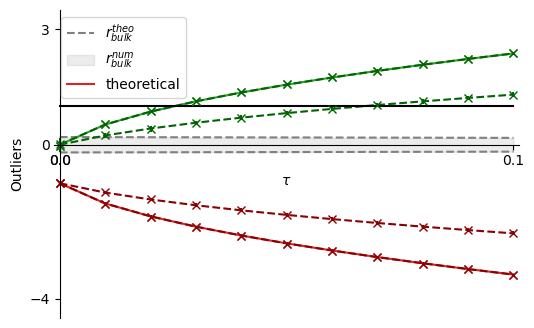

In [18]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(6,4))
### label is r_{bulk}^{num}
ax.plot(tau_series,radius_theo_map,'gray',linestyle='--',label=r'$r_{bulk}^{theo}$')
ax.plot(tau_series,-radius_theo_map,'gray',linestyle='--')
# ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()

ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red', ecolor='tab:red',alpha=1,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-2.5,1.5])
ax.set_yticks([-2,0,1])
ax.set_ylim([-4.5,3.5])
ax.set_yticks([-4,0,3])
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

''' Load data (smallest and largest network size)'''
### loading data and figure out how does the eigenvalue outliers change with the change of Network size N   
### numerical and theoretical eigenvalue outliers
nn = [600,1600]#
itau = -1
eignum_series, eigtheo_series = np.zeros((len(nn),trials-6,2)), np.zeros((len(nn),2))
NNN = (np.array(nn)*5/4).astype(int)
alphass = 1
for idx, netsize in enumerate(NNN):
    # if idx == 0:
    #     continue
    # data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Nscaling_data/GaussianNets/ConnStats_Gauss_16MarPRX_N"+str(netsize)+".npz"
    data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/21Mar_eigenvalues_Gaussian/ConnStats_Gauss_21MarPRX_normlr_N"+str(netsize)+"_lambda0.npz"
    data = np.load(data_name)
    eigvchn_series, eigvchn_theo = data['eigvchn_series'], data['eigvchn_theo']
    ### sort eigvchn_series 
    idx_eff = np.argsort(eigvchn_series[:,-1,0].real)
    idx_eff = idx_eff[3:-3]
    radius_theo_map, radius_num_map = data['radius_theo_map'], data['radius_num_map']
    eignum_series[idx,:,:] = (eigvchn_series[idx_eff,itau,:2])
    eigtheo_series[idx,:] = eigvchn_theo[itau,:]
    print('Netsize:',netsize)
    print('eigvchn_theo:',eigvchn_theo[itau,:])
    ax.plot(tau_series,eigvchn_theo[:,0],'darkred',label='theoretical',alpha=alphass,ls='--')
    ax.plot(tau_series,eigvchn_theo[:,1],'darkgreen',alpha=alphass,ls='--')
    ### plot error bar  
    ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='darkred',ecolor='darkred',alpha=alphass,ls='',elinewidth=1.5)
    ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='darkgreen',ecolor='darkgreen',alpha=alphass,ls='',elinewidth=1.5)
ax.plot(tau_series,np.ones(len(tau_series)),'k',linewidth=1.5)    
plt.show()

Save data

In [78]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d

In [286]:
# params = {'gaverage':gaverage,
#           'gamma':gamma,
#           'NE':NE,
#           'NI':NI,
#           'JE':JE,
#           'JI':JI,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         intg_std_series,intg_std_num_series,leig0mean_series]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "intg_std_series,intg_crossovPop_series,leig0mean_series"]
# data = list_to_dict(lst=lst, string=stg)
# data_name = "---save your file path here---"
# # np.savez(data_name, **data)